In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/sasiabburi/Downloads/PlantVillage 3',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2025-05-09 21:24:59.051848: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-09 21:24:59.052054: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-09 21:24:59.052071: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746806099.052695   20069 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746806099.052780   20069 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

2025-05-09 21:36:38.942022: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


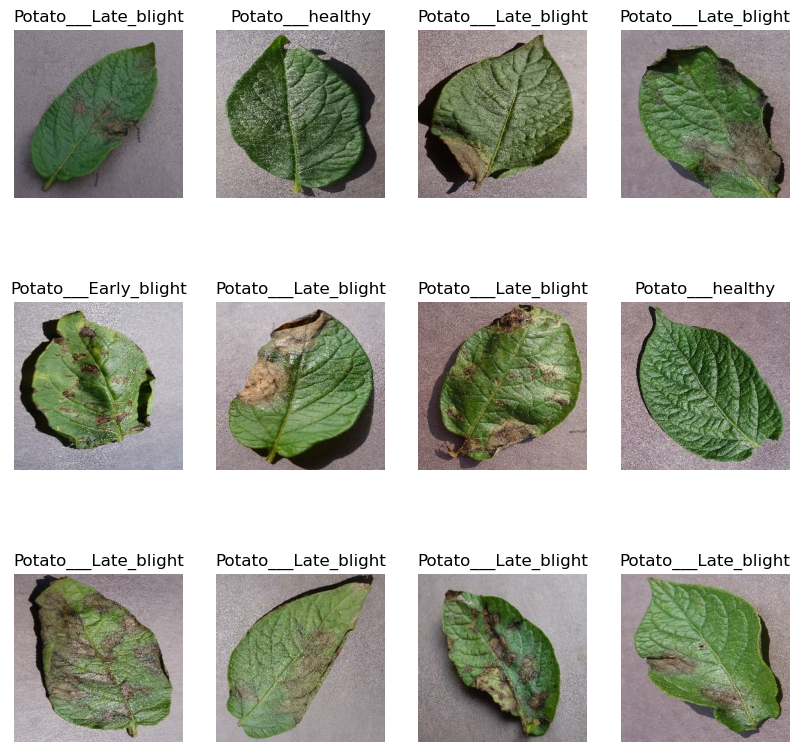

In [14]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        

In [16]:
len(dataset)

68

In [18]:
'''80% ==> training
20% ==> 10% validation ==> 10% training'''

'80% ==> training\n20% ==> 10% validation ==> 10% training'

In [38]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size =  int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
    
    

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds)

54

In [44]:
len(val_ds)

6

In [46]:
len(test_ds)

8

In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
#Layer for resizing and rescaling for preprocessing of data
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [60]:
#data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("Horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [64]:
n_classes = len(class_names)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

In [66]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [74]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds  # ✅ Fixed
)

Epoch 1/50


2025-05-09 22:16:57.248907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1746809217.259410   20069 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 430ms/step - accuracy: 0.4821 - loss: 0.9493 - val_accuracy: 0.5677 - val_loss: 0.8537
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.6041 - loss: 0.8017 - val_accuracy: 0.7031 - val_loss: 0.6604
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.7391 - loss: 0.5781 - val_accuracy: 0.5885 - val_loss: 0.7832
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 391ms/step - accuracy: 0.7706 - loss: 0.4905 - val_accuracy: 0.8646 - val_loss: 0.3415
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.8326 - loss: 0.4007 - val_accuracy: 0.8594 - val_loss: 0.3613
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.8938 - loss: 0.2960 - val_accuracy: 0.9062 - val_loss: 0.2617
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.9274 - loss: 0.2094 - val_accuracy: 0.7500 - val_loss: 0.5573
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.9159 - loss: 0.2154 - val_accuracy: 0.854

In [84]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9278 - loss: 0.2271


In [86]:
scores

[0.2614912688732147, 0.921875]

In [88]:
history

In [90]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [92]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [94]:
history.history["accuracy"]

[0.49537035822868347,
 0.6296296119689941,
 0.7442129850387573,
 0.8229166865348816,
 0.8547453880310059,
 0.8975694179534912,
 0.9247685074806213,
 0.9236111044883728,
 0.9166666865348816,
 0.9340277910232544,
 0.9444444179534912,
 0.9612268805503845,
 0.9618055820465088,
 0.9751157164573669,
 0.9583333134651184,
 0.9733796119689941,
 0.9733796119689941,
 0.9641203880310059,
 0.9728009104728699,
 0.9780092835426331,
 0.9785879850387573,
 0.9826388955116272,
 0.9809027910232544,
 0.9780092835426331,
 0.9878472089767456,
 0.9762731194496155,
 0.9861111044883728,
 0.9837962985038757,
 0.9890046119689941,
 0.9884259104728699,
 0.9820601940155029,
 0.9861111044883728,
 0.984375,
 0.9855324029922485,
 0.9959490895271301,
 0.9918981194496155,
 0.9756944179534912,
 0.9809027910232544,
 0.9907407164573669,
 0.9878472089767456,
 0.9942129850387573,
 0.9936342835426331,
 0.9953703880310059,
 0.9988425970077515,
 0.984375,
 0.9982638955116272,
 0.984375,
 0.9947916865348816,
 0.9849537014961243,


In [96]:
len(history.history["accuracy"])

50

In [98]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

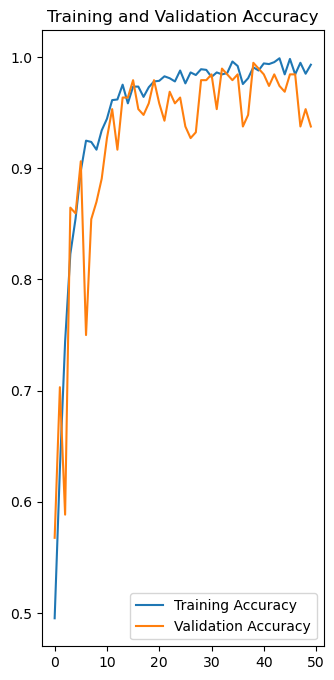

In [106]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Accuracy')

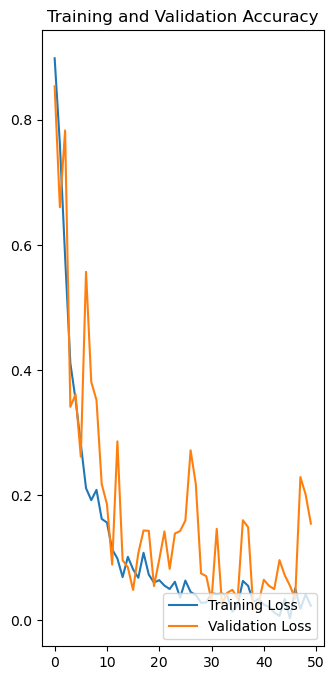

In [108]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

First image to predict:


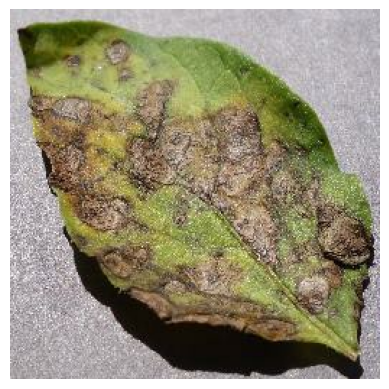

Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
Predicted label: Potato___Early_blight
Prediction scores: [1.0000000e+00 5.8264447e-08 1.6564365e-16]


In [148]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis("off")
    plt.show()

    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    print("Prediction scores:", batch_prediction[0])

In [154]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


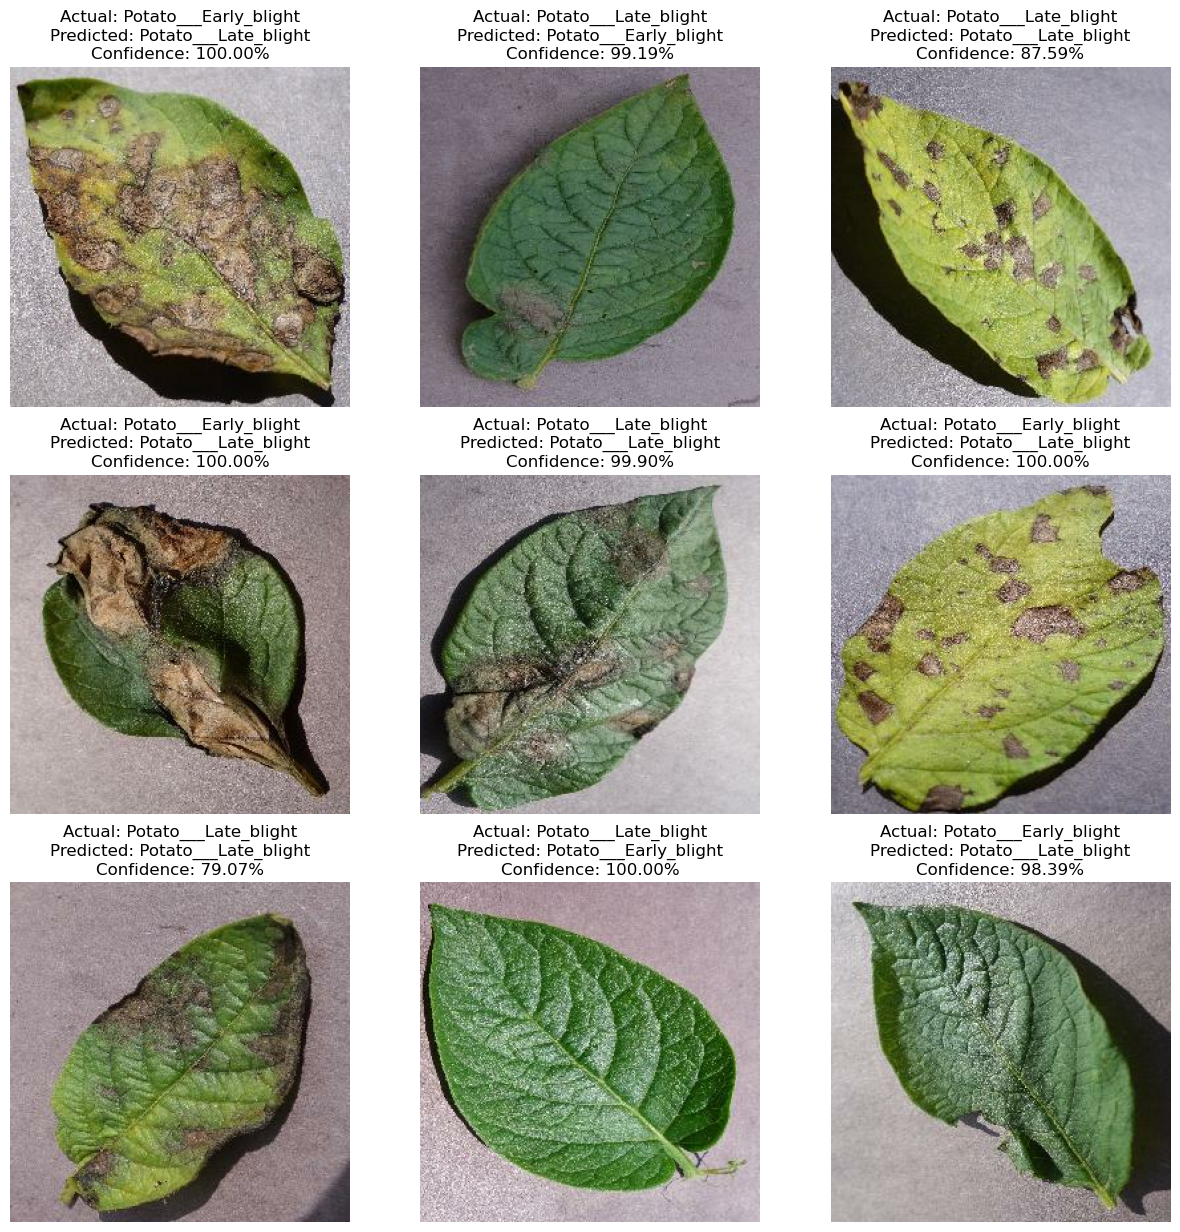

In [156]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        image = image_batch[i].numpy().astype("uint8")
        label = labels_batch[i].numpy()
        
        plt.imshow(image)
        predicted_class, confidence = predict(model, image)
        actual_class = class_names[label]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis("off")